# Acknowledgements

Original Kernel: https://www.kaggle.com/yamsam/ashrae-leak-validation-and-more/notebook#Leak-Validation-for-public-kernels(not-used-leak-data)

Additions: Added a search method to find combination of weights with best score

# All we need is Leak Validation(LV) ?

* **if you like this kernel, please upvote original kernels.**
* update site-4 and site-15

this kernel is still work in progress, but i hope you can find something usefull from this.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm import tqdm_notebook as tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML
from tqdm import tqdm_notebook
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
import lightgbm as lgb
import xgboost as xgb
# import catboost as cb

from sklearn.metrics import mean_squared_error
import feather

In [0]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def sd(col, max_loss_limit=0.001, avg_loss_limit=0.001, na_loss_limit=0, n_uniq_loss_limit=0, fillna=0):
    """
    max_loss_limit - don't allow any float to lose precision more than this value. Any values are ok for GBT algorithms as long as you don't unique values.
                     See https://en.wikipedia.org/wiki/Half-precision_floating-point_format#Precision_limitations_on_decimal_values_in_[0,_1]
    avg_loss_limit - same but calculates avg throughout the series.
    na_loss_limit - not really useful.
    n_uniq_loss_limit - very important parameter. If you have a float field with very high cardinality you can set this value to something like n_records * 0.01 in order to allow some field relaxing.
    """
    is_float = str(col.dtypes)[:5] == 'float'
    na_count = col.isna().sum()
    n_uniq = col.nunique(dropna=False)
    try_types = ['float16', 'float32']

    if na_count <= na_loss_limit:
        try_types = ['int8', 'int16', 'float16', 'int32', 'float32']

    for type in try_types:
        col_tmp = col

        # float to int conversion => try to round to minimize casting error
        if is_float and (str(type)[:3] == 'int'):
            col_tmp = col_tmp.copy().fillna(fillna).round()

        col_tmp = col_tmp.astype(type)
        max_loss = (col_tmp - col).abs().max()
        avg_loss = (col_tmp - col).abs().mean()
        na_loss = np.abs(na_count - col_tmp.isna().sum())
        n_uniq_loss = np.abs(n_uniq - col_tmp.nunique(dropna=False))

        if max_loss <= max_loss_limit and avg_loss <= avg_loss_limit and na_loss <= na_loss_limit and n_uniq_loss <= n_uniq_loss_limit:
            return col_tmp

    # field can't be converted
    return col


def reduce_mem_usage_sd(df, deep=True, verbose=False, obj_to_cat=False):
    numerics = ['int16', 'uint16', 'int32', 'uint32', 'int64', 'uint64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    for col in tqdm_notebook(df.columns):
        col_type = df[col].dtypes

        # collect stats
        na_count = df[col].isna().sum()
        n_uniq = df[col].nunique(dropna=False)
        
        # numerics
        if col_type in numerics:
            df[col] = sd(df[col])

        # strings
        if (col_type == 'object') and obj_to_cat:
            df[col] = df[col].astype('category')
        
        if verbose:
            print(f'Column {col}: {col_type} -> {df[col].dtypes}, na_count={na_count}, n_uniq={n_uniq}')
        new_na_count = df[col].isna().sum()
        if (na_count != new_na_count):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost na values. Before: {na_count}, after: {new_na_count}')
        new_n_uniq = df[col].nunique(dropna=False)
        if (n_uniq != new_n_uniq):
            print(f'Warning: column {col}, {col_type} -> {df[col].dtypes} lost unique values. Before: {n_uniq}, after: {new_n_uniq}')

    end_mem = df.memory_usage(deep=deep).sum() / 1024 ** 2
    percent = 100 * (start_mem - end_mem) / start_mem
    print('Mem. usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'.format(start_mem, end_mem, percent))
    return df
def scoring_fun(weight):
    pred = (sample_leak * weight[None,:]).sum(axis=1)
    return(rmsle(pred,leak_df['meter_reading']))

def rmsle(y_pred, y_test) : 
  assert len(y_test) == len(y_pred)
  return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y_test))**2))

def ensembler_corr(pred):
  corr = pred.corr()
  mask = np.zeros_like(corr, dtype=np.bool)
  mask[np.triu_indices_from(mask)] = True

  rank = np.tril(corr.values,-1)
  m = (rank>0).sum() - (rank>0.97).sum()
  m_gmean, s = 0, 0
  for n in range(m):
      mx = np.unravel_index(rank.argmin(), rank.shape)
      w = (m-n)/m
      m_gmean += w*(np.log1p(pred.iloc[:,mx[0]])+np.log1p(pred.iloc[:,mx[1]]))/2
      s += w
      rank[mx] = 1
  m_gmean = np.expm1(m_gmean/s)
  return(m_gmean)


In [4]:
%%time
root = Path('/content/drive/My Drive/Ashae/new with all shit')

# train_df = pd.read_feather(root/'train.feather')
test_df = pd.read_feather(root/'test.feather', use_threads = True)
#weather_train_df = pd.read_feather(root/'weather_train.feather')
#weather_test_df = pd.read_feather(root/'weather_test.feather')
building_meta_df = pd.read_feather(root/'building_metadata.feather', use_threads = True)

building_meta_df = reduce_mem_usage_sd(building_meta_df)


Mem. usage decreased from  0.02 Mb to  0.02 Mb (23.1% reduction)
CPU times: user 223 ms, sys: 547 ms, total: 770 ms
Wall time: 4.07 s


# Leak Validation for public kernels(not used leak data)

In [0]:
sub_path = '/content/drive/My Drive/Ashae/submission/'
new_shit = '/content/drive/My Drive/Ashae/new with all shit/'
# sample_submission1 = pd.read_csv(sub_path+'submission_catboost_score0.7620486256700786.csv', index_col=0)
# gc.collect()
# sample_submission2 = pd.read_csv(sub_path+'submission_kernel__1.csv', index_col=0)
# gc.collect()
# sample_submission3 = pd.read_csv(sub_path+'submission_kernel__2.csv', index_col=0)
# gc.collect()
# sample_submission4 = pd.read_csv(sub_path+'submission_kernel__3.csv', index_col=0)
# gc.collect()
# sample_submission5 = pd.read_csv(sub_path+'submission_knn.csv', index_col=0)
# gc.collect()
# sample_submission6 = pd.read_csv(sub_path+'submission_linear.csv', index_col=0)
# gc.collect()
# sample_submission7 = pd.read_csv(sub_path+'submission_lgbm_score0.8812202766044857.csv', index_col=0)
# gc.collect()
# sample_submission8 = pd.read_csv(sub_path+'submission_xgb_score0.8816630000000001.csv', index_col=0)
# gc.collect()
# sample_submission9 = pd.read_csv(new_shit+'submission1.csv', index_col=0)
# gc.collect()
# sample_submission10 = pd.read_csv(new_shit+'submission2.csv', index_col=0)
# gc.collect()
# sample_submission11 = pd.read_csv(new_shit+'submission4.csv', index_col=0)
# gc.collect()
# sample_submission12 = pd.read_csv(sub_path+'submission_nn_score0.8610019237596727.csv', index_col=0)
# gc.collect()
# sample_submission13 = pd.read_csv(sub_path+'submission_lgbmdart_score0.8919537527120036.csv', index_col=0)
# gc.collect()

In [0]:
# test_df['pred1'] = pd.read_csv(sub_path+'submission_catboost_score0.7620486256700786.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred2'] = pd.read_csv(sub_path+'submission_kernel__1.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred3'] = pd.read_csv(sub_path+'submission_kernel__2.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred4'] = pd.read_csv(sub_path+'submission_kernel__3.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred5'] = pd.read_csv(sub_path+'submission_knn.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred6'] = pd.read_csv(sub_path+'submission_linear.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred7'] = pd.read_csv(sub_path+'submission_lgbm_score0.8812202766044857.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred8'] = pd.read_csv(sub_path+'submission_xgb_score0.8816630000000001.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred9'] = pd.read_csv(new_shit+'submission1.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred10'] = pd.read_csv(new_shit+'submission2.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred11'] = pd.read_csv(new_shit+'submission4.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred12'] = pd.read_csv(sub_path+'submission_nn_score0.8610019237596727.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred13'] = pd.read_csv(sub_path+'submission_lgbmdart_score0.8919537527120036.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred14'] = pd.read_csv(sub_path+'submission_randomforest.csv', usecols = ['meter_reading'])
# gc.collect()
# test_df['pred15'] = pd.read_csv(sub_path+'submission_adaridge.csv', usecols = ['meter_reading'])
# test_df['pred16'] = pd.read_csv(sub_path+'submission_lgbm_intra_meter.csv', usecols = ['meter_reading'])
# test_df['pred17'] = pd.read_csv(new_shit+'submission_kernel__4.csv', usecols = ['meter_reading'])
# test_df['pred18'] = pd.read_csv(new_shit+'submission_kernel__5.csv', usecols = ['meter_reading'])
# test_df['pred19'] = pd.read_csv(new_shit+'submission_kernel__6.csv', usecols = ['meter_reading'])

# test_df.loc[test_df.pred1<0, 'pred1'] = 0 
# test_df.loc[test_df.pred2<0, 'pred2'] = 0 
# test_df.loc[test_df.pred3<0, 'pred3'] = 0 
# test_df.loc[test_df.pred4<0, 'pred4'] = 0 
# test_df.loc[test_df.pred5<0, 'pred5'] = 0 
# test_df.loc[test_df.pred6<0, 'pred6'] = 0 
# test_df.loc[test_df.pred7<0, 'pred7'] = 0 
# test_df.loc[test_df.pred8<0, 'pred8'] = 0 
# test_df.loc[test_df.pred9<0, 'pred9'] = 0 
# test_df.loc[test_df.pred10<0, 'pred10'] = 0 
# test_df.loc[test_df.pred11<0, 'pred11'] = 0 
# test_df.loc[test_df.pred12<0, 'pred12'] = 0 
# test_df.loc[test_df.pred13<0, 'pred13'] = 0 
# test_df.loc[test_df.pred14<0, 'pred14'] = 0 
# test_df.loc[test_df.pred15<0, 'pred15'] = 0 
# test_df.loc[test_df.pred16<0, 'pred16'] = 0 
# test_df.loc[test_df.pred17<0, 'pred17'] = 0 
# test_df.loc[test_df.pred18<0, 'pred18'] = 0 
# test_df.loc[test_df.pred19<0, 'pred19'] = 0 

# # del  sample_submission1,  sample_submission2,  sample_submission3,sample_submission4,  sample_submission5,  sample_submission6, sample_submission7, sample_submission8,  sample_submission9,  sample_submission10, sample_submission11, sample_submission12, sample_submission13
# gc.collect()

In [0]:
# test_df.to_hdf(sub_path+'test_df.h5',key='test',complib='blosc', complevel=9)

In [0]:
test_df = pd.read_hdf(f'{sub_path}test_df.h5',key='test')

In [7]:
# i'm now using my leak data station kernel to shortcut.
leak_df = pd.read_feather('/content/drive/My Drive/Ashae/new with all shit/leak.feather', use_threads = True)
gc.collect()
leak_df.fillna(0, inplace=True)
leak_df = leak_df[(leak_df.timestamp.dt.year > 2016) & (leak_df.timestamp.dt.year < 2019)]
leak_df.loc[leak_df.meter_reading < 0, 'meter_reading'] = 0 # remove large negative values
leak_df = leak_df[leak_df.building_id!=245]
leak_df = reduce_mem_usage_sd(leak_df)


Mem. usage decreased from 455.38 Mb to 307.38 Mb (32.5% reduction)


In [0]:
gc.collect()
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred1', 'pred2', 'pred3','pred4','pred5','pred6','pred7',
                                  'pred8', 'pred9', 'pred10','pred11','pred12','pred13','pred14','pred15','pred16','row_id']],
                        left_on = ['building_id', 'meter', 'timestamp'],
                        right_on = ['building_id', 'meter', 'timestamp'], how = "left")
gc.collect()
leak_df = leak_df.merge(test_df[['building_id', 'meter', 'timestamp', 'pred17','pred18','pred19','row_id']],
                        left_on = ['building_id', 'meter', 'timestamp'],
                        right_on = ['building_id', 'meter', 'timestamp'], how = "left")
gc.collect()
leak_df = leak_df.merge(building_meta_df[['building_id', 'site_id']], on='building_id', how='left')

In [0]:
leak_df['pred1_l1p'] = np.log1p(leak_df.pred1)
leak_df['pred2_l1p'] = np.log1p(leak_df.pred2)
leak_df['pred3_l1p'] = np.log1p(leak_df.pred3)
leak_df['pred4_l1p'] = np.log1p(leak_df.pred4)
leak_df['pred5_l1p'] = np.log1p(leak_df.pred5)
leak_df['pred6_l1p'] = np.log1p(leak_df.pred6)
leak_df['pred7_l1p'] = np.log1p(leak_df.pred7)
leak_df['pred8_l1p'] = np.log1p(leak_df.pred8)
leak_df['pred9_l1p'] = np.log1p(leak_df.pred9)
leak_df['pred10_l1p'] = np.log1p(leak_df.pred10)
leak_df['pred11_l1p'] = np.log1p(leak_df.pred11)
leak_df['pred12_l1p'] = np.log1p(leak_df.pred12)
leak_df['pred13_l1p'] = np.log1p(leak_df.pred13)
leak_df['pred14_l1p'] = np.log1p(leak_df.pred14)
leak_df['pred15_l1p'] = np.log1p(leak_df.pred15)
leak_df['pred16_l1p'] = np.log1p(leak_df.pred16)
leak_df['pred17_l1p'] = np.log1p(leak_df.pred17)
leak_df['pred18_l1p'] = np.log1p(leak_df.pred18)
leak_df['pred19_l1p'] = np.log1p(leak_df.pred19)

leak_df['meter_reading_l1p'] = np.log1p(leak_df.meter_reading)

num_blend = 19

In [0]:
leak_df[leak_df.pred1_l1p.isnull()]

,building_id,meter,meter_reading,timestamp,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,pred10,pred11,pred12,pred13,pred14,pred15,pred16,row_id_x,pred17,pred18,pred19,row_id_y,site_id,pred1_l1p,pred2_l1p,pred3_l1p,pred4_l1p,pred5_l1p,pred6_l1p,pred7_l1p,pred8_l1p,pred9_l1p,pred10_l1p,pred11_l1p,pred12_l1p,pred13_l1p,pred14_l1p,pred15_l1p,pred16_l1p,pred17_l1p,pred18_l1p,pred19_l1p,meter_reading_l1p


score1= 1.0202101274083464


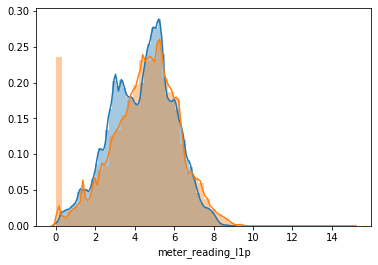

score2= 0.9892354633004811


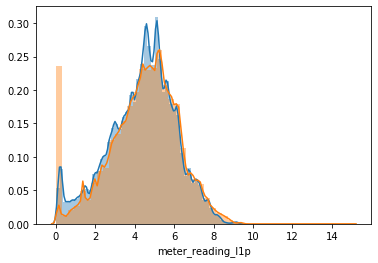

score3= 0.9980967384682735


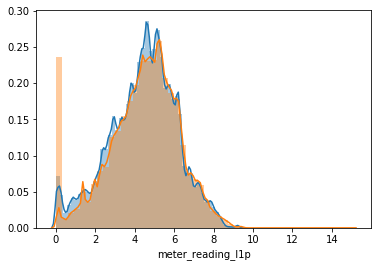

score4= 0.9864602177871736


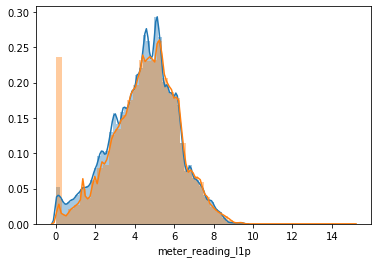

score5= 0.996944991079959


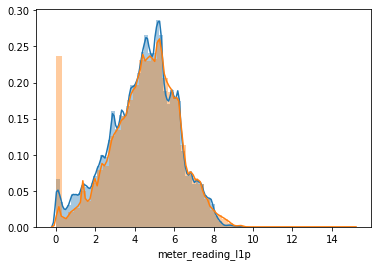

score6= 1.015462096247547


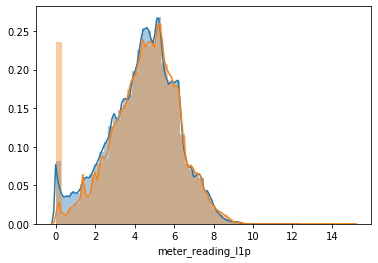

score7= 0.9914927487549663


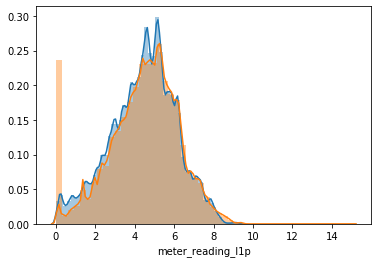

score8= 0.9733417296804485


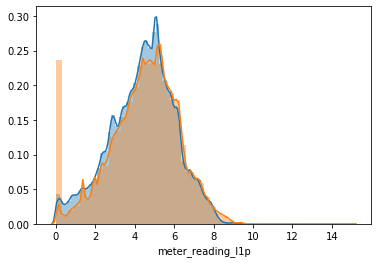

score9= 1.0011899846980759


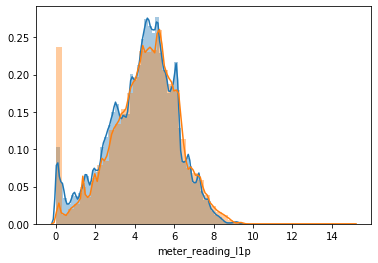

score10= 0.9871310088653706


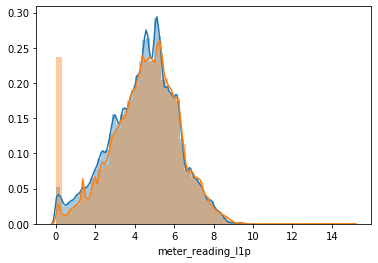

score11= 1.0093888920533003


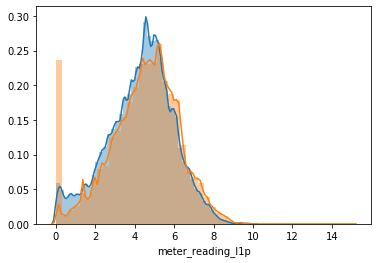

score12= 1.0097177211699517


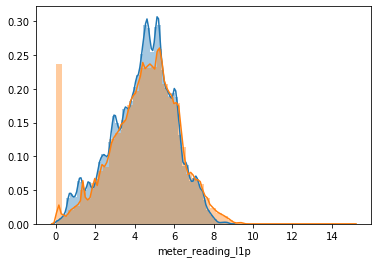

score13= 0.9813953002164495


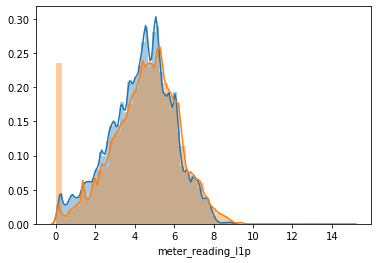

score14= 1.0181486134333964


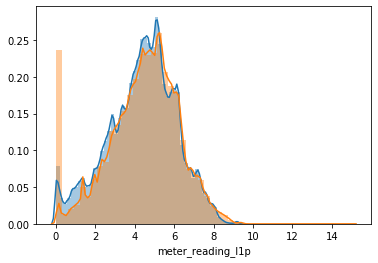

score15= 1.0327516545731332


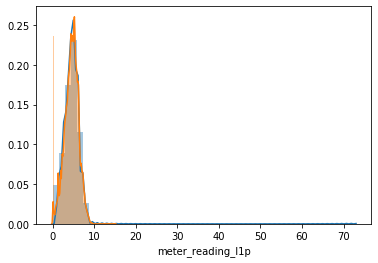

score16= 0.979715010940501


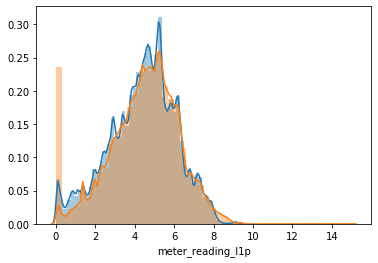

score17= 0.9892354633004811


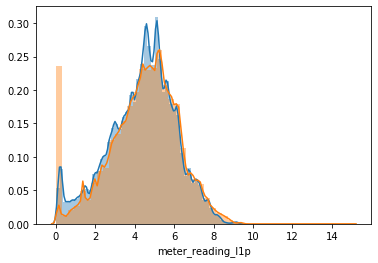

score18= 0.9781318522282868


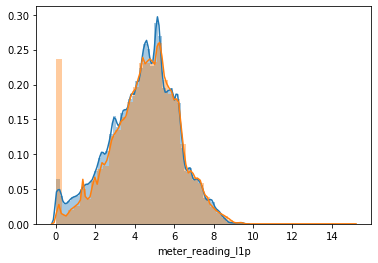

score19= 0.9934951647539941


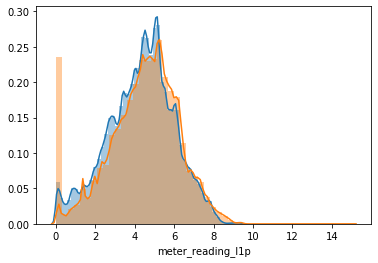

In [0]:
for x in tqdm_notebook(np.arange(1,num_blend + 1)):
    sns.distplot(leak_df[['pred'+str(x)+'_l1p']])
    sns.distplot(leak_df.meter_reading_l1p)
    leak_score = np.sqrt(mean_squared_error(leak_df[['pred'+str(x)+'_l1p']], leak_df.meter_reading_l1p))
    print (f'score{x}=', leak_score)
    plt.show()

In [0]:
# ashrae-kfold-lightgbm-without-leak-1-08 looks best

# Leak Validation for Blending

A one idea how we can use LV usefull is blending. We probably can find best blending method without LB probing and it's means we can save our submission.

mean score= 0.9705711486753207


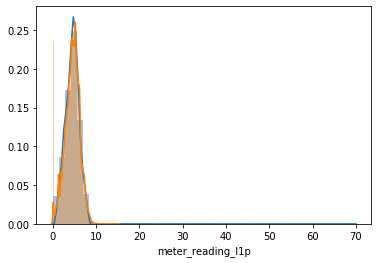

In [0]:
leak_df['mean_pred'] = np.mean(leak_df[['pred'+str(x) for x in np.arange(1,num_blend + 1)]].values, axis=1)
leak_df['mean_pred_l1p'] = np.log1p(leak_df.mean_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.mean_pred_l1p, leak_df.meter_reading_l1p))


sns.distplot(leak_df.mean_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print ('mean score=', leak_score) #0.9705711486753207

meadian score= 0.9595476524880522


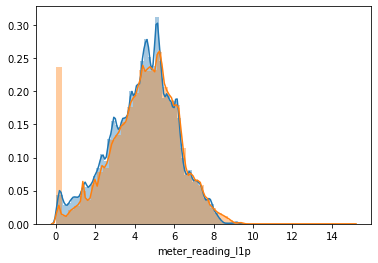

In [0]:
leak_df['median_pred'] = np.median(leak_df[['pred'+str(x) for x in np.arange(1,num_blend + 1)]].values, axis=1)
leak_df['median_pred_l1p'] = np.log1p(leak_df.median_pred)
leak_score = np.sqrt(mean_squared_error(leak_df.median_pred_l1p, leak_df.meter_reading_l1p))

sns.distplot(leak_df.median_pred_l1p)
sns.distplot(leak_df.meter_reading_l1p)

print ('meadian score=', leak_score) #0.9595476524880522

Ummm... it looks mean blending is beter than median blending

# CORR BLEND

In [0]:
sample_leak = leak_df[['pred'+str(x) for x in np.arange(1,num_blend+1)]]
test_leak = test_df[['pred'+str(x) for x in np.arange(1,num_blend+1)]]
cols = sample_leak.columns

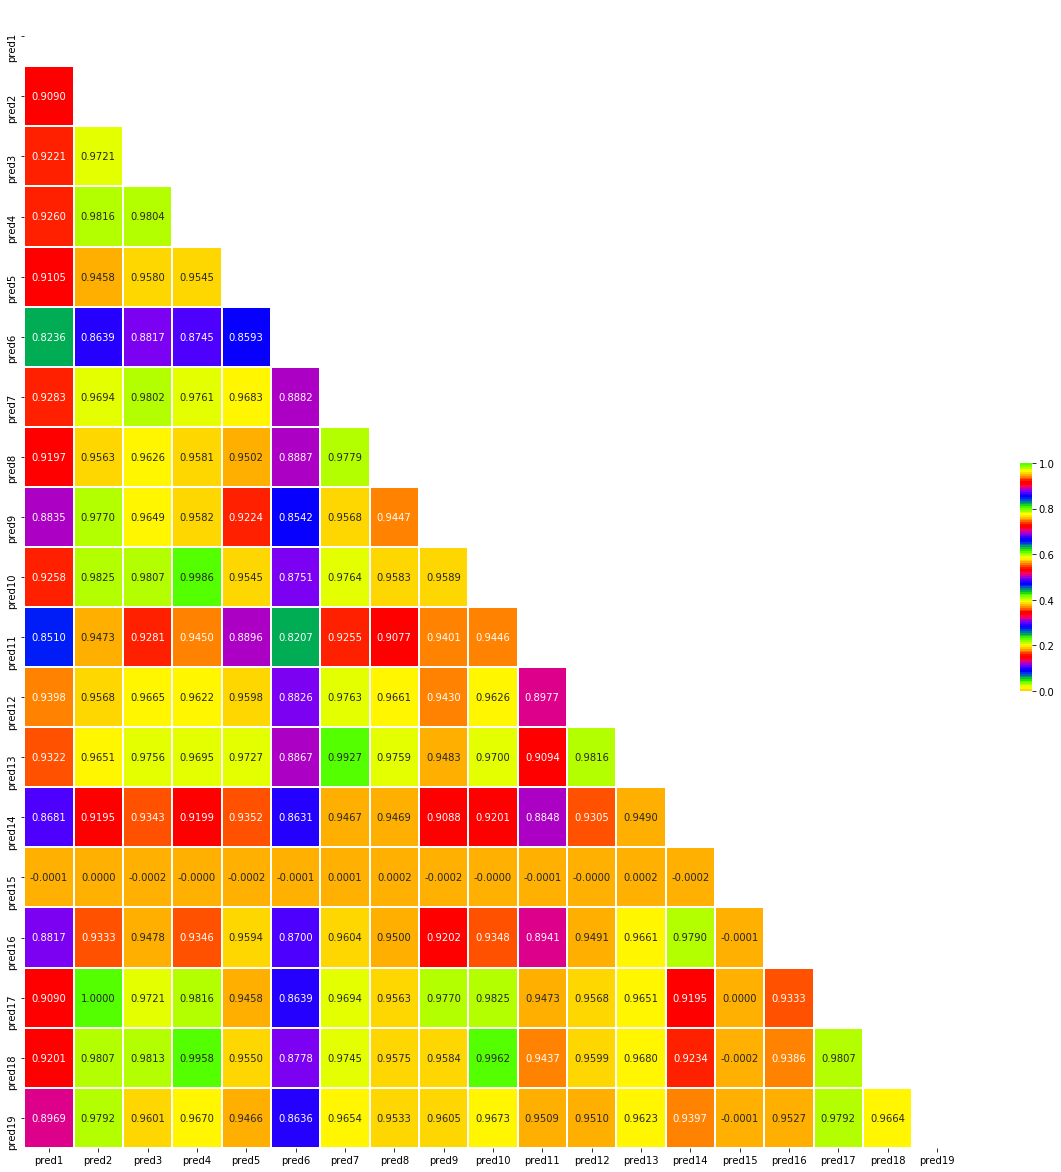

In [0]:
corr = sample_leak.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                annot=True,fmt='.4f', cbar_kws={"shrink":.2})

rank = np.tril(corr.values,-1)
rank[rank<0.7] = 1
m = (rank>0).sum()
m_gmean, s = 0, 0

for n in range(m):
    mx = np.unravel_index(rank.argmin(), rank.shape)
    w = (m-n)/m
    m_gmean += w*(np.log1p(sample_leak.iloc[:,mx[0]])+np.log1p(sample_leak.iloc[:,mx[1]]))/2
    s += w
    rank[mx] = 1
m_gmean = np.expm1(m_gmean/s)


In [0]:
# from scipy.optimize import Bounds, minimize
# from sklearn.metrics import mean_squared_error


# fconst = lambda w: 1 - sum(w)

# cons   = ({'type':'eq','fun':fconst})
# x0 = np.array([1 for x in range(sample_leak.shape[1])])
# x = x0/len(x0)

# b = (0.0, 1.0) 
# bounds = tuple([b for x in range(sample_leak.shape[1])])

# res = minimize(scoring_fun, x0,
#                options={'disp': True,'maxiter':100},bounds = bounds,
#                 constraints = cons)
# print(res)
# weight = res['x']/sum(res['x'])

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.959440297385765
            Iterations: 14
            Function evaluations: 210
            Gradient evaluations: 14
     fun: 0.959440297385765
     jac: array([0.08101883, 0.0806646 , 0.10884088, 0.09034213, 0.0847245 ,
       0.08073691, 0.10271998, 0.08065119, 0.08080521, 0.09091643,
       0.08052035, 0.10909817, 0.08868776])
 message: 'Optimization terminated successfully.'
    nfev: 210
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([4.05905730e-02, 1.92391762e-01, 1.68051337e-18, 8.83624771e-18,
       1.35525272e-18, 2.04560695e-02, 1.22514845e-17, 3.19810723e-01,
       3.84620156e-01, 0.00000000e+00, 4.21307163e-02, 6.45100293e-18,
       0.00000000e+00])


score gmean low correlation 0.960632259326809


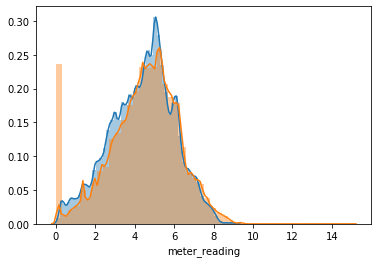

In [0]:
sns.distplot(np.log1p(m_gmean), label = 'gmean low corr')
sns.distplot(np.log1p(leak_df.meter_reading), label = 'real')
leak_score = rmsle(m_gmean.loc[leak_df.index],leak_df['meter_reading'])
print('score gmean low correlation', leak_score)
plt.show() #0.9625117613138096

score scipy ensemble 0.959440297385765


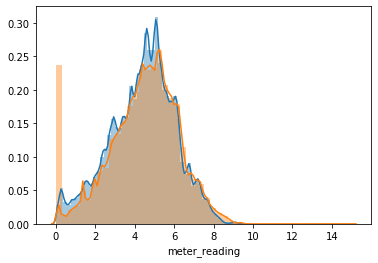

In [0]:
# weight = res['x']/sum(res['x'])
# pred = (sample_leak*weight[None,:]).sum(axis=1)
# sns.distplot(np.log1p(pred), label = 'scipy ensemble')
# sns.distplot(np.log1p(leak_df.meter_reading), label = 'real')
# leak_score = rmsle(pred.loc[leak_df.index],leak_df['meter_reading'])
# print('score scipy ensemble', leak_score)
# plt.show()

In [12]:
slicer = test_df[['building_id']].merge(building_meta_df[['building_id','site_id']], on='building_id', how='left')
slicer = reduce_mem_usage_sd(slicer)
gc.collect()


Mem. usage decreased from 437.43 Mb to 437.43 Mb (0.0% reduction)


14

In [0]:
#gc.collect()
#slicer['building_meter'] = slicer['building_id'].astype(str) +'_'+\
 #                   slicer['meter'].astype(str)
#slicer = reduce_mem_usage_sd(slicer,obj_to_cat = True)

In [0]:
def gmean_ensembler(df,cols,plot=True):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    if plot:
        # Set up the matplotlib figure
        f, ax = plt.subplots(figsize=(len(cols)+2, len(cols)+2))

        # Draw the heatmap with the mask and correct aspect ratio
        _ = sns.heatmap(corr,mask=mask,cmap='prism',center=0, linewidths=1,
                        annot=True,fmt='.4f', cbar_kws={"shrink":.2})
        plt.show()
    rank = np.tril(corr.values,-1)
    rank[rank<0.7] = 1
    m = (rank>0).sum() - (rank==1).sum()
    m_gmean, s = 0, 0

    for n in range(m):
        mx = np.unravel_index(rank.argmin(), rank.shape)
        w = (m-n)/m
        m_gmean += w*(np.log1p(df.iloc[:,mx[0]])+np.log1p(df.iloc[:,mx[1]]))/2
        s += w
        rank[mx] = 1
    m_gmean = np.expm1(m_gmean/s)
    return(m_gmean)


In [14]:
slicer2 = leak_df[['building_id']].merge(building_meta_df[['building_id','site_id']], on='building_id', how='left')
slicer2 = reduce_mem_usage_sd(slicer2)
gc.collect()


Mem. usage decreased from 125.23 Mb to 125.23 Mb (0.0% reduction)


0

In [0]:
pred = pd.DataFrame({'pred':np.zeros(sample_leak.shape[0])})
for site in tqdm_notebook(slicer2.site_id.unique()):
    pred.loc[slicer2.site_id==site,'pred'] = gmean_ensembler(sample_leak[slicer2.site_id==site],cols,plot=False)
    
sns.distplot(np.log1p(pred), label = 'gmean low corr')
sns.distplot(np.log1p(leak_df.meter_reading), label = 'real')
leak_score = np.sqrt(mean_squared_error(np.log1p(pred), leak_df.meter_reading_l1p))
print('score gmean low correlation', leak_score)
plt.show()#0.9523074326840506

NameError: ignored

In [0]:
gc.collect()
pred = pd.DataFrame({'pred':np.zeros(test_leak.shape[0])})
for site in tqdm_notebook(slicer.site_id.unique()):
    pred.loc[slicer.site_id==site,'pred'] = gmean_ensembler(test_leak[slicer.site_id==site],cols,plot=False)

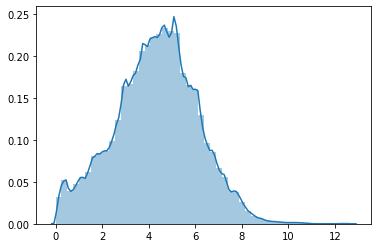

In [0]:
sns.distplot(np.log1p(pred), label = 'gmean low corr')


# Find Best Weight

In [0]:
#N = 10
#scores = np.zeros(N,)
#for i in range(N):
 #   p = i * 1./N
  #  v = p * leak_df['pred1'].values + (1.-p) * leak_df ['pred3'].values
   # vl1p = np.log1p(v)
    #scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

In [0]:
#plt.plot(scores)

In [0]:
#best_weight = np.argmin(scores) *  1./N
#print (scores.min(), best_weight)

In [0]:
## and more
#scores = np.zeros(N,)
#for i in range(N):
 #   p = i * 1./N
  #  v =  p * (best_weight * leak_df['pred1'].values + (1.-best_weight) * leak_df ['pred3'].values) + (1.-p) * leak_df ['pred2'].values
   # vl1p = np.log1p(v)
    #scores[i] = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))

In [0]:
#plt.plot(scores)

In [0]:
#best_weight2 = np.argmin(scores) *  1./N
#print (scores.min(), best_weight2)
# its seams better than simple mean 0.92079717

# Heuristic way

### Create List of Possible Combinations

In [0]:
#all_combinations = list(np.linspace(0.2,0.5,31))
#all_combinations

### Create List of All Possible Combinations of Three Lists

In [0]:
#import itertools

In [0]:
#l = [all_combinations, all_combinations, all_combinations]
# remember to do the reverse!
#all_l = list(itertools.product(*l)) + list(itertools.product(*reversed(l)))

### Filter Combinations to Have Those With Sum of Weights > 0.95 

Reason being weight sum of 0.96 led to LB score of 0.99

In [0]:
#filtered_combis = [l for l in all_l if l[0] + l[1] + l[2] > 0.93 and l[0] + l[1] + l[2] < 1.03]

In [0]:
#print(len(filtered_combis))

## Begin the Search For Combination With Lowest Score!

In [0]:
#%%time
#best_combi = [] # of the form (i, score)
#for i, combi in tqdm_notebook(enumerate(filtered_combis)):
 #   #print("Now at: " + str(i) + " out of " + str(len(filtered_combis))) # uncomment to view iterations
  #  score1 = combi[0]
   # score2 = combi[1]
    #score3 = combi[2]
#    v = score1 * leak_df['pred1'].values + score2 * leak_df['pred3'].values + score3 * leak_df['pred2'].values
 #   vl1p = np.log1p(v)
  #  curr_score = np.sqrt(mean_squared_error(vl1p, leak_df.meter_reading_l1p))
   # 
    #if best_combi:
#        prev_score = best_combi[0][1]
 #       if curr_score < prev_score:
  #          best_combi[:] = []
   #         best_combi += [(i, curr_score)]
    #else:
#        best_combi += [(i, curr_score)]
            
#score = best_combi[0][1]
#print(score)

# Submit

In [0]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))

# extract best combination
#final_combi = filtered_combis[best_combi[0][0]]
#w1 = final_combi[0]
#w2 = final_combi[1]
#w3 = final_combi[2]
#print("The weights are: w1=" + str(w1) + ", w2=" + str(w2) + ", w3=" + str(w3))

sample_submission['meter_reading'] = pred#w1 * test_df.pred1 +  w2 * test_df.pred3  + w3 * test_df.pred2
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

In [0]:
sample_submission.head()

,row_id,meter_reading
0,0,150.105874
1,1,68.813651
2,2,9.362696
3,3,250.884771
4,4,1135.161044


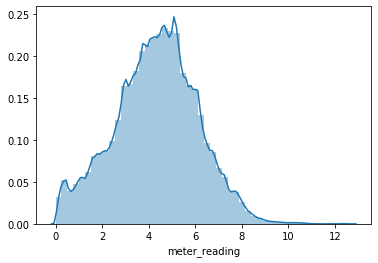

In [0]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [0]:
gc.collect()

26

In [0]:
sample_submission.to_csv('/content/drive/My Drive/Ashae/original_gmean.csv', index=False)

In [0]:
gc.collect()
# leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

In [0]:
sns.distplot(np.log1p(sample_submission.meter_reading))

In [0]:
sample_submission.head()

In [0]:
sample_submission.to_csv('/content/drive/My Drive/Ashae/enseble_gmean_leaked.csv', index=False)

In [16]:
pred = pd.DataFrame({'pred':np.zeros(test_leak.shape[0])})
for site in tqdm_notebook(slicer.site_id.unique()):
    pred.loc[slicer.site_id==site,'pred'] = np.median(test_df.loc[slicer.site_id==site,cols].values, axis=1)
gc.collect()

0

In [0]:
sample_submission = pd.read_feather(os.path.join(root, 'sample_submission.feather'))
gc.collect()
sample_submission['meter_reading'] = pred
gc.collect()
sample_submission.loc[sample_submission.meter_reading < 0, 'meter_reading'] = 0

In [20]:
sample_submission.head()

,row_id,meter_reading
0,0,169.533400
1,1,82.680286
2,2,9.999644
3,3,279.609085
4,4,1208.386100


0

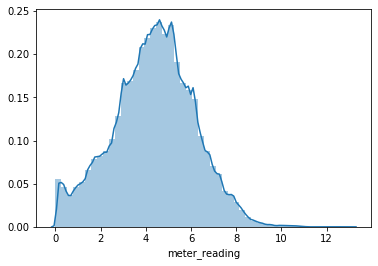

In [21]:
sns.distplot(np.log1p(sample_submission.meter_reading))
sample_submission.to_csv('/content/drive/My Drive/Ashae/original_median.csv', index=False)
gc.collect()

In [0]:
# leak_df = leak_df[['meter_reading', 'row_id']].set_index('row_id').dropna()
sample_submission.loc[leak_df.index, 'meter_reading'] = leak_df['meter_reading']

In [0]:
sample_submission.to_csv('/content/drive/My Drive/Ashae/enseble_median.csv', index=False)

# Future Work

- Increase the range of weights
- Vary tolerance for sum of weights (currently tol = 0.95)